# Laboratorio 1: Telefonía movil

> **Análisis de Series Temporales** - *Diplomatura en Ciencias de Datos, Aprendizaje Automático
y sus aplicaciones.*

> Gonzalo Zigarán

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Lectura de datos

In [3]:
data = pd.read_csv('Telefonia_movil.csv')
data.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
17,2017,2,15.315.167,6293563,21608730,Abr-Jun 2017
18,2017,3,15.106.275,6308373,21414647,Jul-Sept 2017
19,2017,4,14.164.552,5380710,19545262,Oct-Dic 2017
20,2018,1,13.851.254,5958717,19809971,Ene-Mar 2018
21,2018,2,14.388.755,6290155,20678910,Abr-Jun 2018


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
Año                                   22 non-null int64
Trimestre                             22 non-null int64
Minutos pospago salientes (miles)     22 non-null object
Minutos prepago salientes (miles)     22 non-null int64
Total de minutos salientes (miles)    22 non-null int64
Periodo                               22 non-null object
dtypes: int64(4), object(2)
memory usage: 1.1+ KB
None


### Indice en datetime

Convertimos las columnas que hacen referencia a la fecha del registro a un valor `datetime` e indexeamos el DataFrame por este valor.

In [5]:
data.index = pd.PeriodIndex((data['Año'].astype(str) + 'Q' + data['Trimestre'].astype(str) ), freq='Q')
data = data.drop(columns=['Año', 'Trimestre', 'Periodo'])
data.sample(5)

,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles)
2017Q4,14.164.552,5380710,19545262
2017Q1,14.630.269,6209983,20840252
2017Q2,15.315.167,6293563,21608730
2013Q3,10.315.484,7335154,17650638
2013Q4,9.809.515,6250549,16060064


### Columnas a enteros

Se observa que la columna *Minutos pospago salientes (miles)* no está en el formato deseado, no es un valor numérico sino un string.

In [6]:
data['Minutos pospago salientes (miles)'] = data['Minutos pospago salientes (miles)'].apply(lambda x: int(x.replace('.', '')))

### Nombres de columnas

Cambiamos los nombres de las columnas

In [7]:
data = data.rename(columns={'Minutos pospago salientes (miles)' : 'pospago', 
                            'Minutos prepago salientes (miles)' : 'prepago',
                            'Total de minutos salientes (miles)' : 'total' })
data.sample(5)

,pospago,prepago,total
2014Q1,10128751,5799223,15927974
2013Q4,9809515,6250549,16060064
2013Q2,9512689,7108640,16621329
2013Q1,8785943,6582117,15368060
2013Q3,10315484,7335154,17650638


## Visualización de las series

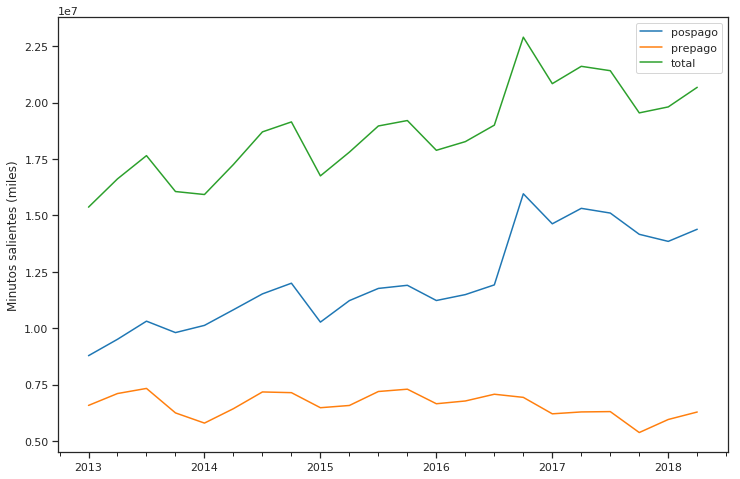

In [8]:
data.plot()
plt.ylabel('Minutos salientes (miles)')
plt.show()

In [9]:
data.describe()

,pospago,prepago,total
count,2.200000e+01,2.200000e+01,2.200000e+01
mean,1.209691e+07,6.604273e+06,1.870118e+07
std,2.077349e+06,5.251805e+05,1.990543e+06
min,8.785943e+06,5.380710e+06,1.536806e+07
25%,1.044198e+07,6.291007e+06,1.735731e+07
50%,1.164553e+07,6.580968e+06,1.883452e+07
75%,1.408623e+07,7.100940e+06,1.974379e+07
max,1.596076e+07,7.335154e+06,2.289966e+07


Vamos a trabajar con la serie de los minutos totales salientes:

In [10]:
y = data.total

## Random Walk

In [11]:
h = 4
test = pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred = pd.Series(np.repeat(y.iloc[-1], h), index=test)
pred

2018Q3    20678910
2018Q4    20678910
2019Q1    20678910
2019Q2    20678910
Freq: Q-DEC, dtype: int64

In [12]:
resid = y - y.shift(1)
sigma = resid.std()
round(sigma,3)

1464911.401

In [13]:
intv = pd.concat([pred - stats.norm.ppf(0.95) * sigma * np.sqrt(np.arange(1,h+1)),
                   pred + stats.norm.ppf(0.95) * sigma * np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q3,1.826935e+07,2.308847e+07
2018Q4,1.727127e+07,2.408655e+07
2019Q1,1.650542e+07,2.485240e+07
2019Q2,1.585978e+07,2.549804e+07


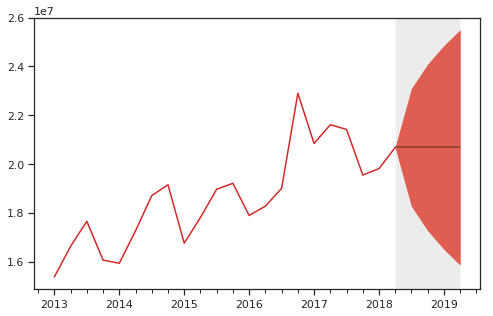

In [14]:
from plotting import fanchart

point_pred = (intv[0] + intv[1])/2

fig, ax = fanchart(y, point_pred, intv, intv, intv)

plt.show()

## Exponencial Smoothing

In [15]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
# model_ses.summary() # summary isn't implemented in 0.9, looks it'll be avaible in 0.10
alpha_ses = model_ses.model.params['smoothing_level']
rmse_ses = sm.tools.eval_measures.rmse(y,fitted_ses)
print(' Valor del parámtero alpha:  {0:.3f}'.format(alpha_ses))
print(' RMSE:                       {0:.3f}'.format(rmse_ses))

 Valor del parámtero alpha:  0.536
 RMSE:                       1357838.607


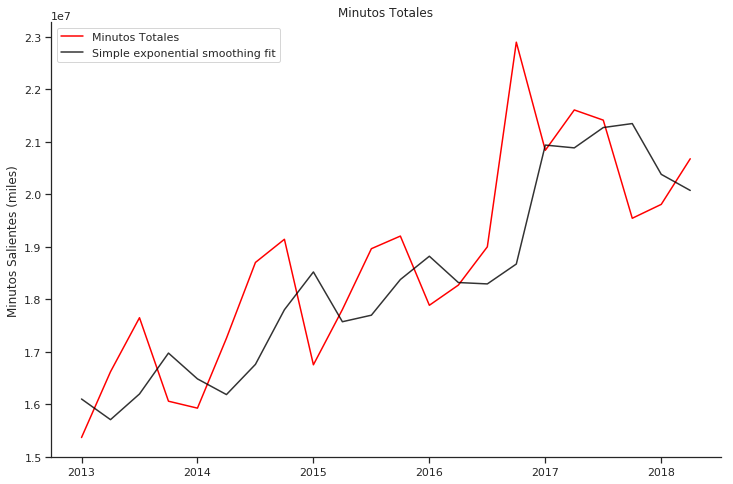

In [16]:
fig, ax = plt.subplots()
y.plot(color='red', label='Minutos Totales')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos Salientes (miles)')
ax.set_title('Minutos Totales')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Diagnóstico del modelos

Computamos los residuos:

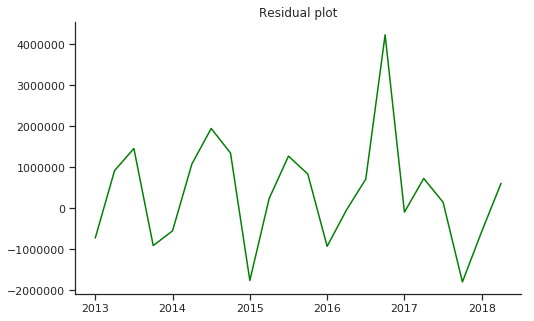

In [17]:
resid = y - fitted_ses

fig, ax = plt.subplots(figsize=(8,5))
resid.plot(color='green')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

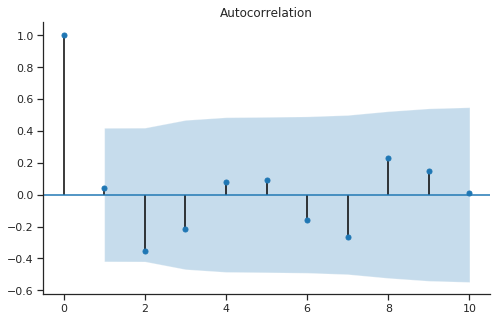

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax)
sns.despine()
plt.show()

Media de los residuos: 364247.15


/home/gon/anaconda3/envs/series-temporales/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


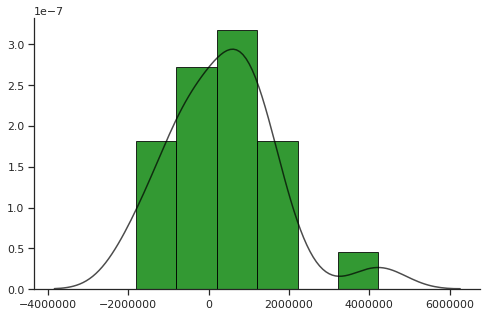

In [19]:
def hist(series):
    fig, ax = plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': 'green'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

print('Media de los residuos: %.2f' % resid.mean())
hist(resid)
plt.show()

Los residuos no están correlacionados. Además no tienen una distribución gaussiana y no es 0, es bastante mayor.

## Validación de los modelos

In [20]:
validation = y['2015Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2015Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns = ['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm

,RW,SES,Actual
2015Q1,19144961.0,1.914496e+07,16753809.0
2015Q2,16753809.0,1.675381e+07,17806395.0
2015Q3,17806395.0,1.764777e+07,18965537.0
2015Q4,18965537.0,1.818201e+07,19206111.0
2016Q1,19206111.0,1.872956e+07,17887638.0
2016Q2,17887638.0,1.830887e+07,18271759.0
2016Q3,18271759.0,1.829925e+07,19001229.0
2016Q4,19001229.0,1.860414e+07,22899656.0
2017Q1,22899656.0,2.289966e+07,20840252.0
2017Q2,20840252.0,2.097571e+07,21608730.0


In [21]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,1581859.402,437675.158
SES,1648098.884,455148.668


Se puede observar que para este ejemplo el modelo de *Random Walk* genera menos error, auqnue los 2 parecen funcionar bastante mal.

## Forecast

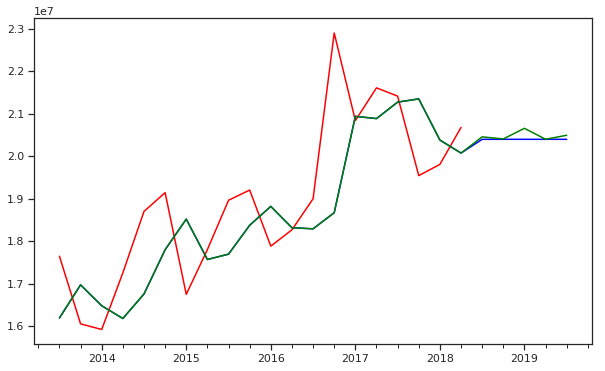

In [22]:
h = 5
w = h*2
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([y, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i == 0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = y[-2*w:].plot(color='red',figsize=(10,6))
pd.concat([orig_fit[-2*w:],pred_expanding]).plot(ax=ax,color='blue')
pd.concat([orig_fit[-2*w:],pred_rolling]).plot(ax=ax,color='green')